# The Battle of Neighborhoods - Tokyo (Week 2)

## 1. Introduction

Tokyo (東京, Tōkyō) is Japan's capital and the world's most populous metropolis. It is also one of Japan's 47 prefectures, consisting of 23 central city wards and multiple cities, towns and villages west of the city center. The Izu and Ogasawara Islands are also part of Tokyo.

Today, Tokyo offers a seemingly unlimited choice of shopping, entertainment, culture and dining to its visitors. The city's history can be appreciated in districts such as Asakusa and in many excellent museums, historic temples and gardens. Contrary to common perception, Tokyo also offers a number of attractive green spaces in the city center and within relatively short train rides at its outskirts.

## problem 

During the daytime, specially in the morning and lunch hours, office areas provide huge opportunities for restaurants. Reasonably priced (one lunch meal $ 8\text{\$} $) shops are usually always full during the lunch hours (11 am -- 2 pm) and, given this scenario, we will go through the benefits and pitfalls of opening a breakfast cum lunch restaurants in highly densed office places. Usually the profit margin for a decent restaurant lie within $15 - 20\% $ range but, it can even go high enough to $35\%

<img src="tokyo.jpg"/>


# 2. Data Preparation

In [44]:
# import the necessary Libraries 
import sys
import requests
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


import io
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

### *Firstly, scrapping the data and get the names of wards, population, district names from wikipedia*

In [45]:
url = requests.get('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo').text
soup = BeautifulSoup(url,'lxml')
Wards_Tokyo_Table = soup.find('table', {'class':'wikitable sortable'})
### preparation of the table 

Name=[]
Kanji = []
Pop = []
Density = []
num = []
flag = []
Area = []
Major_District = []

for row in Wards_Tokyo_Table.findAll("tr"):
    #print (row)    
    Ward = row.findAll('td')
    #print (len(Ward))
    print (Ward)
    if len(Ward)==8: #Only extract table body not heading
        print (Ward[0])
        #print postcode[1]
        #print postcode[2]
        num.append(Ward[0].find(text=True))
        flag.append(Ward[1].findAll('a')) # useless
        Name.append(Ward[2])
        Kanji.append(Ward[3].find(text=True))
        Pop.append(Ward[4])
        Area.append(Ward[5].find(text=True))
        Major_District.append(Ward[7].find(text=True))
            

# Area 

# print (Area[3])  the first element of the area needs a replacement with the true value 5100
Area = ['5100' if x=='0' else x for x in Area]
New_Area = []

# change the type of Area list 
for l in range(len(Area)):
    x=Area[l].replace(",","")
    print (x)
    New_Area.append(x)

New_Area=[int(s) for s in New_Area]

#print (New_Area) # the list elements are already in accordance with the table


# Name of the Wards

new_names = []
for n in range(len(Name)):
    print (Name[n])
    names = Name[n].findAll('a')
    new_names.append(names) 

print (new_names)

flat_new_names_list = [item for sublist in new_names for item in sublist]
print (flat_new_names_list)

Wards_names= []
#now 
for name_wards in flat_new_names_list:
        Wards_names.append(name_wards.get('title'))

print (Wards_names)

# replace the elements in the list that contains 'Tokyo' with only the ward names
replace_names={'Chiyoda, Tokyo':'Chiyoda', 'Chūō, Tokyo':'Chuo', 'Minato, Tokyo':'Minato', 
               'Sumida, Tokyo':'Sumida', 'Koto, Tokyo':'Koto', 'Ōta, Tokyo':'Ota', 'Nakano, Tokyo':'Nakano', 
               'Kita, Tokyo':'Kita', 'Arakawa, Tokyo':'Arakawa', 'Adachi, Tokyo':'Adachi', 'Edogawa, Tokyo':'Edogawa'}


Wards_names1 = [replace_names.get(n1,n1) for n1 in Wards_names]


# population

population = []
for p in range(len(Pop)):
    print ((Pop[p]))
    pops = Pop[p].text[1:9]
    print (Pop[p].text[1:9])
    #populs = Pop[p].find('visibility:hidden;color:transparent;')
    population.append(pops) 
print (population)


New_population = []
for po in range(len(population)):
    xy=population[po].replace(",","")
    print (xy)
    New_population.append(xy)

New_population=[int(s1) for s1 in New_population]
# print (New_population)


# Major Districts


replace_districts = {'Nagatachō':'Nagatacho', 'Hongō':'Hongo', 'Kinshichō':'Kinshicho', 'Ōmori': 'Omori', 
                     'Kōenji':'Koenji', 'Arakawa, Machiya, ':'Arakawa', 'Ayase, ':'Ayase', 'Kasai, Koiwa\n':'Kasai'}


Major_District_names1 = [replace_districts.get(n2,n2) for n2 in Major_District]


df=pd.DataFrame(Wards_names1,columns=['Ward'])
df['Area_SqKm'] = New_Area
df['Population'] = New_population
df['Major_District'] = Major_District_names1
df.index = np.arange(1, len(df) + 1) # reset the index so that it starts from 1. 

# use of geopy geocoders
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Tokyo_explorer")
df['Major_Dist_Coord']= df['Major_District'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
# replace some of the wrong coordinates 


Lat_list = df['Latitude'].tolist()
Long_list = df['Longitude'].tolist()
print ("Old latitude list: ", Lat_list)
print ("Old Longitude list: ", Long_list)
replace_latitudes = {32.5093796:35.7088, 23.0131338:35.6722, -38.9047057:35.5884, -5.3498001:35.6634}
replace_longitudes = {-116.2970014:139.7601, -80.8328748:139.8061, 175.7552111:139.7279, 21.424098:139.8731}

latitudes_new = [replace_latitudes.get(n3,n3) for n3 in Lat_list]
longtitudes_new = [replace_longitudes.get(n4,n4) for n4 in Long_list]
print (latitudes_new)
print (longtitudes_new)

Tokyo_df = df.drop(['Latitude', 'Longitude'], axis=1)
# #df.drop(['Longitude'], axis=1, inplace=True)
# Tokyo_df


Tokyo_df['Dist_Latitude'] = latitudes_new
Tokyo_df['Dist_Longitude'] = longtitudes_new

Tokyo_df

#Tokyo_df.to_csv('Tokyo_df_Coord.csv')

[]
[<td>01</td>, <td><a class="image" href="/wiki/File:Flag_of_Chiyoda,_Tokyo.svg"><img alt="Flag of Chiyoda, Tokyo.svg" class="thumbborder" data-file-height="540" data-file-width="810" decoding="async" height="33" src="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/50px-Flag_of_Chiyoda%2C_Tokyo.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/75px-Flag_of_Chiyoda%2C_Tokyo.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/100px-Flag_of_Chiyoda%2C_Tokyo.svg.png 2x" width="50"/></a></td>, <td><a href="/wiki/Chiyoda,_Tokyo" title="Chiyoda, Tokyo">Chiyoda</a></td>, <td><span lang="ja" title="Japanese-language text">千代田区</span>
</td>, <td><span style="visibility:hidden;color:transparent;">0</span><span style="visibility:hidden;color:transparent;">0</span>59,441</td>, <td><span style="visibility:hidden;color:transparent;">0</span>5,100</td>, <td><span style="visibil

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503
3,Minato,12180,248071,Odaiba,35.619050,139.779364
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632
5,Bunkyō,19790,223389,Hongo,35.175376,137.013476
6,Taitō,19830,200486,Ueno,35.711821,139.777569
7,Sumida,18910,260358,Kinshicho,35.696312,139.815043
8,Koto,12510,502579,Kiba,35.672200,139.806100
9,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910
10,Meguro,19110,280283,Meguro,35.621250,139.688014


# 3. Exploaratory Data analysis

In [47]:
Tokyo_df = pd.read_csv('Tokyo_df_Coord.csv', index_col=[0])
#remove the unnamed column 
Tokyo_df.head(3)

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503
3,Minato,12180,248071,Odaiba,35.619050,139.779364


In [48]:
response_obj = requests.get('https://utinokati.com/en/details/land-market-value/area/Tokyo/').text
#print (type (response_obj))
soup = BeautifulSoup(response_obj,'lxml')
#print (soup.prettify())

In [49]:
Price_Tokyo_Table = soup.find('tbody')
#Price_Tokyo_Table

In [50]:
Name=[]
Avg_price = []


for row in Price_Tokyo_Table.findAll("tr"):
    
    price = row.findAll('td')
    Name.append(price[0].find(text=True))
    Avg_price.append(price[2].find(text=True))   

#print(Name)

price_df = pd.DataFrame(Name,columns=['Ward'])
price_df['Avg_price_sqKm'] = Avg_price




price_df['Avg_price_sqKm'] = price_df['Avg_price_sqKm'].map(lambda x: x.rstrip('JPY/sq.m').rstrip('0123456789'))

#print (price_df.dtypes)
# Change the average price column datatype 
Avg_price_list = price_df['Avg_price_sqKm'].tolist()
New_Avg_price = []

for pr in range(len(Avg_price_list)):
    x = Avg_price_list[pr].replace(",", "")
    New_Avg_price.append(x)


Avg_price_new=[int(s) for s in New_Avg_price]

price_df.drop(['Avg_price_sqKm'], axis=1, inplace=True)

price_df['Average_Price(SqKm)'] = New_Avg_price

price_df

,Ward,Average_Price(SqKm)
0,Chiyoda-Ku,2839779
1,Chuo-Ku,1876597
2,Minato-Ku,2075876
3,Shinjuku-Ku,875098
4,Bunkyo-Ku,952715
5,Taito-Ku,970843
6,Sumida-Ku,605382
7,Koto-Ku,653035
8,Shinagawa-Ku,775938
9,Meguro-Ku,857665


In [51]:

## Select info only for 5 relevant wards Chiyoda, Chuo, Shinjuku, Shibuya, Shinagawa. 
## 
pd.options.mode.chained_assignment = None
ward_list = ['Chiyoda-Ku', 'Chuo-Ku', 'Shinjuku-Ku', 'Shibuya-Ku', 'Shinagawa-Ku']
price_df_selected = price_df.loc[price_df['Ward'].isin(ward_list)]
price_df_selected.index = np.arange(1, len(price_df_selected) + 1)
#Ward_names = price_df_selected['Ward'].map(lambda y: str(y)[:-3]) # strip -Ku from the ward names
price_df_selected['Ward']=price_df_selected['Ward'].map(lambda y: str(y)[:-3]) 
#price_df_selected.drop(['Ward'], axis=1, inplace=True)
#price_df_selected['Ward']=Ward_names
price_df_selected

,Ward,Average_Price(SqKm)
1,Chiyoda,2839779
2,Chuo,1876597
3,Shinjuku,875098
4,Shinagawa,775938
5,Shibuya,1193412


In [52]:
## Similarly select those five wards from the Tokyo Wards Data-Frame
ward_list1 = ['Chiyoda', 'Chuo', 'Shinjuku', 'Shibuya', 'Shinagawa']
Tokyo_df_selected = Tokyo_df.loc[Tokyo_df['Ward'].isin(ward_list1)]
Tokyo_df_selected

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632
9,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910
13,Shibuya,15080,227850,Shibuya,35.664596,139.698711


In [53]:
# Merge the two dataframes according to the ward names 

Tokyo_df_selected_final = Tokyo_df_selected.merge(price_df_selected, on='Ward', how='left')
Tokyo_df_selected_final.index = np.arange(1, len(Tokyo_df_selected_final)+1)
Tokyo_df_selected_final.to_csv('Tokyo_5_Wards.csv')
Tokyo_df_selected_final

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm)
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469,2839779
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503,1876597
3,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,875098
4,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910,775938
5,Shibuya,15080,227850,Shibuya,35.664596,139.698711,1193412


In [54]:
# get Tokyo, Tokyo Latitude and Longitude 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Tokyo'

geolocator = Nominatim(user_agent="Tokyo_explorer")
location = geolocator.geocode(address)
Tokyo_latitude = location.latitude
Tokyo_longitude = location.longitude
print('The geograpical coordinates of Tokyo are {}, {}.'.format(Tokyo_latitude, Tokyo_longitude))

The geograpical coordinates of Tokyo are 35.6828387, 139.7594549.


In [63]:
import folium
# # create map of Most Busy Office Areas of Tokyo using latitude and longitude values
Tokyo_5Wards = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Tokyo_df_selected_final['Dist_Latitude'], Tokyo_df_selected_final['Dist_Longitude'], 
                           Tokyo_df_selected_final['Major_District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='Fuchsia',
        fill=True,
        fill_color='#E6E6FA',
        fill_opacity=0.7).add_to(Tokyo_5Wards)  
    
Tokyo_5Wards

## FourSquare API

In [55]:
CLIENT_ID = 'TEWBDLTPVR5QX533IRSGISZ1QIUVWMCYSGL3TNDM42HZ5ZJF' #'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'JZCD2YQYWQEBDCD3UKBSCBJKUHSE0A10NH4EEG2E1XTB2BRL' #'your-client-secret' # your Foursquare Secret
VERSION = '20210510' # Foursquare API version

print('My credentails:')
print('My CLIENT_ID: ' + CLIENT_ID)
print('My CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
My CLIENT_ID: TEWBDLTPVR5QX533IRSGISZ1QIUVWMCYSGL3TNDM42HZ5ZJF
My CLIENT_SECRET:JZCD2YQYWQEBDCD3UKBSCBJKUHSE0A10NH4EEG2E1XTB2BRL


##  Exploring Major Districts

In [56]:
radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

## creating Dataframe of 5 busiest wards of tokyo

In [57]:
Tokyo_5_Dist_Venues = getNearbyVenues(names=Tokyo_df_selected_final['Major_District'],
                                   latitudes=Tokyo_df_selected_final['Dist_Latitude'],
                                   longitudes=Tokyo_df_selected_final['Dist_Longitude']
                                  )

Nagatacho
Nihonbashi
Shinjuku
Shinagawa
Shibuya


In [58]:
print ("Shape of the Venues Dataframe: ", Tokyo_5_Dist_Venues.shape)
Tokyo_5_Dist_Venues.tail(3)

Shape of the Venues Dataframe:  (500, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
497,Shibuya,35.664596,139.698711,Kiraku (喜楽),35.659047,139.696957,Ramen Restaurant
498,Shibuya,35.664596,139.698711,DJ BAR Bridge,35.659466,139.701199,Nightclub
499,Shibuya,35.664596,139.698711,CBGK シブゲキ!!,35.659196,139.698461,Indie Theater


In [59]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Tokyo_5_Dist_Venues_only_restaurant = Tokyo_5_Dist_Venues[Tokyo_5_Dist_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Tokyo_5_Dist_Venues_only_restaurant.index = np.arange(1, len(Tokyo_5_Dist_Venues_only_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Tokyo_5_Dist_Venues_only_restaurant.shape)
Tokyo_5_Dist_Venues_only_restaurant.head(3)

Shape of the Data-Frame with Venue Category only Restaurant:  (187, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
2,Nagatacho,35.675618,139.743469,Sushi Isshin (鮨 一新),35.672589,139.739399,Sushi Restaurant
3,Nagatacho,35.675618,139.743469,Akasaka Fukinuki (赤坂ふきぬき),35.673257,139.738332,Unagi Restaurant


In [61]:

## Show in Map the Top Rated Restaruants in the Top 5 Districts

map_restaurants = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on the Major Districts
Districts = ['Nagatacho', 'Nihonbashi', 'Shinjuku', 'Shinagawa', 'Shibuya']

x = np.arange(len(Districts))

rainbow = ['#7CFC00', '#9932CC','#00BFFF','#00FA9A' ,'#DC143C']

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(Tokyo_5_Dist_Venues_only_restaurant['Venue_Lat'], 
                                  Tokyo_5_Dist_Venues_only_restaurant['Venue_Long'], 
                                  Tokyo_5_Dist_Venues_only_restaurant['Venue_Category'], 
                                  Tokyo_5_Dist_Venues_only_restaurant['District']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Districts.index(distr)-1],
        fill=True,
        fill_color=rainbow[Districts.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
       
map_restaurants

In [26]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Tokyo_5_Dist_Venues['Venue_Category'].unique())))
## We can check some of the categories randomly  
print (Tokyo_5_Dist_Venues[['Venue_Category']][70:75])

There are 131 unique categories.
         Venue_Category
70            BBQ Joint
71             Beer Bar
72  Szechuan Restaurant
73                Hotel
74          Coffee Shop


In [27]:
print (Tokyo_5_Dist_Venues['Venue_Category'].value_counts())

BBQ Joint               25
Japanese Restaurant     25
Sake Bar                22
Ramen Restaurant        20
Café                    19
                        ..
Shopping Mall            1
Gym / Fitness Center     1
Souvenir Shop            1
Sandwich Place           1
Train Station            1
Name: Venue_Category, Length: 131, dtype: int64


## top 10 most frequently occuring venue category

In [65]:
# create a dataframe of top 10 categories
Tokyo_5_Dist_Venues_Top10 = Tokyo_5_Dist_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_5_Dist_Venues_Top10=Tokyo_5_Dist_Venues_Top10.reset_index()
#Tokyo_5_Dist_Venues_Top10

Tokyo_5_Dist_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Tokyo_5_Dist_Venues_Top10

,Venue_Category,Frequency
0,BBQ Joint,25
1,Japanese Restaurant,25
2,Sake Bar,22
3,Ramen Restaurant,20
4,Café,19
5,Bar,17
6,Convenience Store,17
7,Sushi Restaurant,14
8,Hotel,14
9,Chinese Restaurant,14


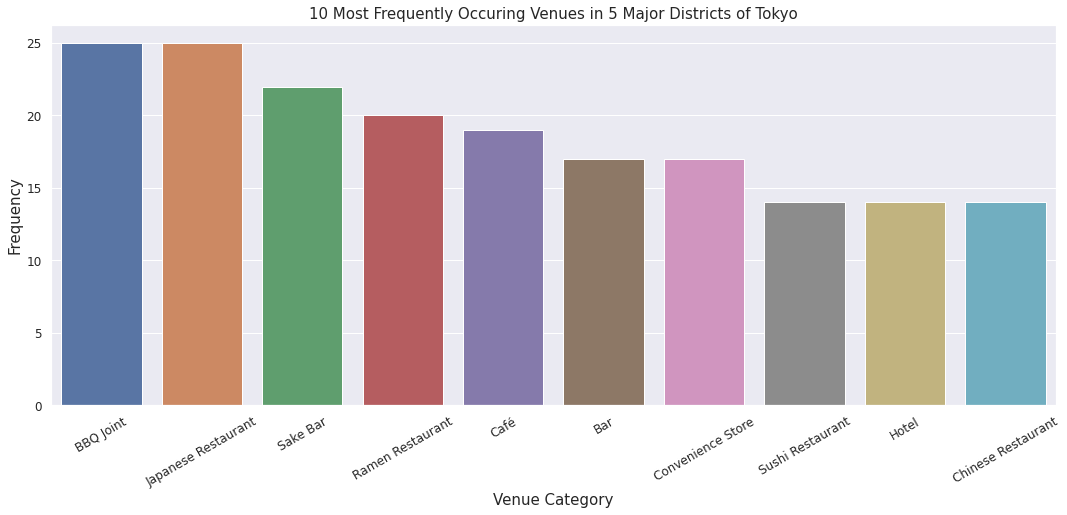

In [66]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_5_Dist_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in 5 Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [67]:

### Use One Hot Encoding to Get More Information about the Venue Categories 
Tokyo_5_Dist_Venues_onehot = pd.get_dummies(Tokyo_5_Dist_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add district column back to dataframe
Tokyo_5_Dist_Venues_onehot['District'] = Tokyo_5_Dist_Venues['District'] 
### move district column to the first column
fixed_columns = [Tokyo_5_Dist_Venues_onehot.columns[-1]] + list(Tokyo_5_Dist_Venues_onehot.columns[:-1])
Tokyo_5_Dist_Venues_onehot = Tokyo_5_Dist_Venues_onehot[fixed_columns]
###Tokyo_5_Dist_Venues_onehot.head(3)

In [68]:
Tokyo_5_Dist_Venues_Grouped = Tokyo_5_Dist_Venues_onehot.groupby('District').mean().reset_index()
Tokyo_5_Dist_Venues_Grouped.index = np.arange(1, len(Tokyo_5_Dist_Venues_Grouped)+1)
Tokyo_5_Dist_Venues_Grouped


,District,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,...,Train Station,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Vegetarian / Vegan Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Yakitori Restaurant,Yoshoku Restaurant
1,Nagatacho,0.00,0.00,0.01,0.00,0.00,0.00,0.09,0.01,0.03,...,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.02,0.01
2,Nihonbashi,0.00,0.00,0.00,0.00,0.02,0.00,0.04,0.03,0.01,...,0.00,0.00,0.02,0.02,0.00,0.03,0.00,0.00,0.03,0.04
3,Shibuya,0.01,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.04,...,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.01,0.00
4,Shinagawa,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.02,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02
5,Shinjuku,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.07,...,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.02,0.01


In [32]:

num_top_venues = 5

for places in Tokyo_5_Dist_Venues_Grouped['District']:
    print("%%%%%%%%%"+places+"%%%%%%%%")
    temp = Tokyo_5_Dist_Venues_Grouped[Tokyo_5_Dist_Venues_Grouped['District'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

%%%%%%%%%Nagatacho%%%%%%%%
                 Venue  Freq
0  Japanese Restaurant  0.10
1            BBQ Joint  0.09
2          Coffee Shop  0.07
3                Hotel  0.05
4  Szechuan Restaurant  0.05


%%%%%%%%%Nihonbashi%%%%%%%%
                 Venue  Freq
0  Japanese Restaurant  0.08
1                 Café  0.07
2   Yoshoku Restaurant  0.04
3   Chinese Restaurant  0.04
4     Sushi Restaurant  0.04


%%%%%%%%%Shibuya%%%%%%%%
               Venue  Freq
0               Café  0.09
1        Record Shop  0.04
2  French Restaurant  0.04
3                Bar  0.04
4          Nightclub  0.03


%%%%%%%%%Shinagawa%%%%%%%%
               Venue  Freq
0  Convenience Store  0.17
1   Ramen Restaurant  0.09
2           Sake Bar  0.06
3          BBQ Joint  0.05
4      Grocery Store  0.05


%%%%%%%%%Shinjuku%%%%%%%%
              Venue  Freq
0          Sake Bar  0.10
1               Bar  0.07
2         BBQ Joint  0.06
3  Ramen Restaurant  0.05
4               Pub  0.04




In [33]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_top10_venues_sorted = pd.DataFrame(columns=columns)
District_top10_venues_sorted['District'] = Tokyo_5_Dist_Venues_Grouped['District']

for ind in np.arange(Tokyo_5_Dist_Venues_Grouped.shape[0]):
    District_top10_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tokyo_5_Dist_Venues_Grouped.iloc[ind, :], num_top_venues)

    
District_top10_venues_sorted.index = np.arange(1, len(District_top10_venues_sorted)+1)
District_top10_venues_sorted.head(5)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Nagatacho,Japanese Restaurant,BBQ Joint,Coffee Shop,Szechuan Restaurant,Hotel,Chinese Restaurant,Korean Restaurant,Sake Bar,Bar,Ramen Restaurant
2,Nihonbashi,Japanese Restaurant,Café,BBQ Joint,Chinese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Hotel,Yakitori Restaurant,Soba Restaurant,Bakery
3,Shibuya,Café,French Restaurant,Record Shop,Bar,Chinese Restaurant,Nightclub,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant
4,Shinagawa,Convenience Store,Ramen Restaurant,Sake Bar,Grocery Store,BBQ Joint,Sushi Restaurant,Park,Donburi Restaurant,Soba Restaurant,Yakitori Restaurant
5,Shinjuku,Sake Bar,Bar,BBQ Joint,Ramen Restaurant,Pub,Japanese Restaurant,Chinese Restaurant,Café,Boutique,Rock Club


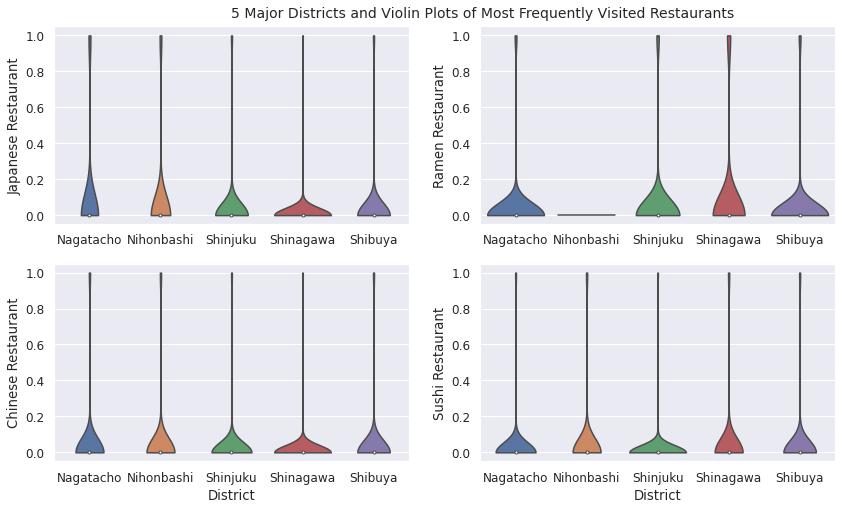

In [70]:

# Let's try Categorical plot 


fig = plt.figure(figsize=(14,8))

sns.set(font_scale=1.1)
ax = plt.subplot(2,2,1)
sns.violinplot(x="District", y="Japanese Restaurant", data=Tokyo_5_Dist_Venues_onehot, cut=0);
plt.xlabel("")
ax = plt.subplot(2,2,2)
sns.violinplot(x="District", y="Ramen Restaurant", data=Tokyo_5_Dist_Venues_onehot, cut=0);
plt.xlabel("")
plt.subplot(2,2,3)
sns.violinplot(x="District", y="Chinese Restaurant", data=Tokyo_5_Dist_Venues_onehot, cut=0);
plt.subplot(2,2,4)
sns.violinplot(x="District", y="Sushi Restaurant", data=Tokyo_5_Dist_Venues_onehot, cut=0);
#ax.title.set_text("5 Major Districts and Violin Plots of Most Frequently Visited Restaurants")
ax.text(-4.0, 1.1, '5 Major Districts and Violin Plots of Most Frequently Visited Restaurants', fontsize=14)
plt.savefig ("Violin_plots_Dist_Frequent_Restaurant.png", dpi=240)
plt.show()

[52, 44, 30, 32, 29]


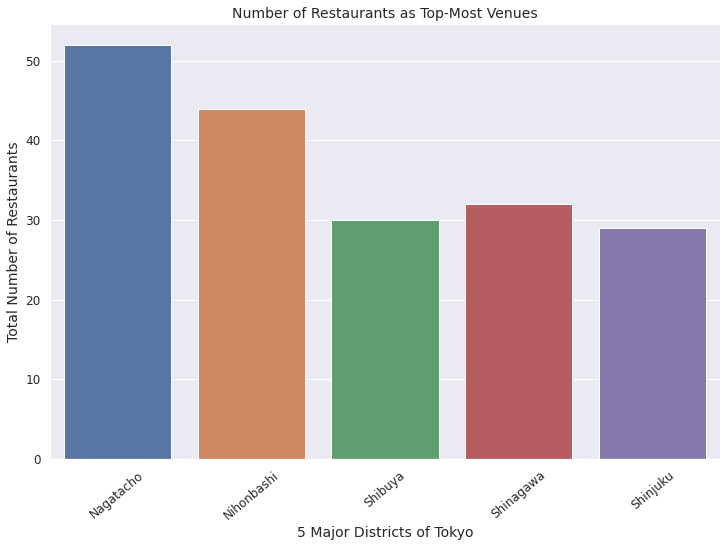

In [35]:

#try groupby to play with restaurant 
Tokyo_5_Dist_Venues_restaurant = Tokyo_5_Dist_Venues.groupby(['District'])['Venue_Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Tokyo_5_Dist_Venues_restaurant_df = Tokyo_5_Dist_Venues_restaurant.to_frame().reset_index()
Tokyo_5_Dist_Venues_restaurant_df.columns = ['District', 'Number of Restaurant']
#Tokyo_5_Dist_Venues_restaurant.columns = ['District', 'Number of Restaurant']
#print (type(Tokyo_5_Dist_Venues_restaurant))
Tokyo_5_Dist_Venues_restaurant_df.index = np.arange(1, len(Tokyo_5_Dist_Venues_restaurant_df)+1)

#print ("shape of the dataframe: ", Tokyo_5_Dist_Venues_restaurant_df.shape)
#print (Tokyo_5_Dist_Venues_restaurant_df.head(5))
#print (type(Tokyo_5_Dist_Venues_restaurant_df[['Number of Restaurant']]))
list_rest_no = Tokyo_5_Dist_Venues_restaurant_df['Number of Restaurant'].to_list()
print (list_rest_no)
fig = plt.figure(figsize=(12,8))
bar = sns.barplot(x='District', y='Number of Restaurant', data=Tokyo_5_Dist_Venues_restaurant_df)

bar.set_ylabel("Total Number of Restaurants", fontsize=14)
bar.set_xlabel("5 Major Districts of Tokyo", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Restaurants as Top-Most Venues", fontsize=14)
#plt.savefig("No_of_Rest_as_Top_Venues.png", dpi=240)
plt.show()

In [36]:
# set number of clusters
kclusters = 3

Tokyo_grouped_clustering = Tokyo_5_Dist_Venues_Grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the 5 Cluster labels :",  kmeans.labels_[0:5])

Check the 5 Cluster labels : [2 0 0 1 2]


In [37]:
# add clustering labels

District_top10_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

Tokyo_5_Dist_Coordinate_Cluster_merged = Tokyo_df_selected_final

#merge the inital Tokyo Dataframe with Sorted Most Visited places for each neighborhood

Tokyo_5_Dist_Coordinate_Cluster_merged = Tokyo_5_Dist_Coordinate_Cluster_merged.join \
                                        (District_top10_venues_sorted.set_index('District'), on='Major_District')

Tokyo_5_Dist_Coordinate_Cluster_merged.head()

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469,2839779,2,Japanese Restaurant,BBQ Joint,Coffee Shop,Szechuan Restaurant,Hotel,Chinese Restaurant,Korean Restaurant,Sake Bar,Bar,Ramen Restaurant
2,Chuo,14460,147620,Nihonbashi,35.684068,139.774503,1876597,0,Japanese Restaurant,Café,BBQ Joint,Chinese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Hotel,Yakitori Restaurant,Soba Restaurant,Bakery
3,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,875098,2,Sake Bar,Bar,BBQ Joint,Ramen Restaurant,Pub,Japanese Restaurant,Chinese Restaurant,Café,Boutique,Rock Club
4,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910,775938,1,Convenience Store,Ramen Restaurant,Sake Bar,Grocery Store,BBQ Joint,Sushi Restaurant,Park,Donburi Restaurant,Soba Restaurant,Yakitori Restaurant
5,Shibuya,15080,227850,Shibuya,35.664596,139.698711,1193412,0,Café,French Restaurant,Record Shop,Bar,Chinese Restaurant,Nightclub,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant


In [38]:
# create map
map_clusters = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tokyo_5_Dist_Coordinate_Cluster_merged['Dist_Latitude'], 
                                  Tokyo_5_Dist_Coordinate_Cluster_merged['Dist_Longitude'], 
                                  Tokyo_5_Dist_Coordinate_Cluster_merged['Major_District'], 
                                  Tokyo_5_Dist_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [39]:
# create map
map_restaurants10 = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
Districts = ['Nagatacho', 'Nihonbashi', 'Shinjuku', 'Shinagawa', 'Shibuya']

# add markers to the map
for lat, lon, poi, cluster in zip(Tokyo_5_Dist_Coordinate_Cluster_merged['Dist_Latitude'], 
                                  Tokyo_5_Dist_Coordinate_Cluster_merged['Dist_Longitude'], 
                                  Tokyo_5_Dist_Coordinate_Cluster_merged['Major_District'], 
                                  Tokyo_5_Dist_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[Districts.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

## Clustering

In [40]:

Tokyo_Cluster1 = Tokyo_5_Dist_Coordinate_Cluster_merged.loc[Tokyo_5_Dist_Coordinate_Cluster_merged['Cluster Label'] == 0, 
                                    Tokyo_5_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_5_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster1.shape[0]))
Tokyo_Cluster1

No of Neighbourhood in Cluster Label 0: 2


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Nihonbashi,35.684068,139.774503,1876597,0,Japanese Restaurant,Café,BBQ Joint,Chinese Restaurant,Sushi Restaurant,Yoshoku Restaurant,Hotel,Yakitori Restaurant,Soba Restaurant,Bakery
5,Shibuya,35.664596,139.698711,1193412,0,Café,French Restaurant,Record Shop,Bar,Chinese Restaurant,Nightclub,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant


In [41]:
Tokyo_Cluster2 = Tokyo_5_Dist_Coordinate_Cluster_merged.loc[Tokyo_5_Dist_Coordinate_Cluster_merged['Cluster Label'] == 1, 
                                    Tokyo_5_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_5_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 1: %d" %(Tokyo_Cluster2.shape[0]))
Tokyo_Cluster2

No of Neighbourhood in Cluster Label 1: 1


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Shinagawa,35.599252,139.73891,775938,1,Convenience Store,Ramen Restaurant,Sake Bar,Grocery Store,BBQ Joint,Sushi Restaurant,Park,Donburi Restaurant,Soba Restaurant,Yakitori Restaurant


In [42]:

Tokyo_Cluster3 = Tokyo_5_Dist_Coordinate_Cluster_merged.loc[Tokyo_5_Dist_Coordinate_Cluster_merged['Cluster Label'] == 2, 
                                    Tokyo_5_Dist_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_5_Dist_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 2: %d" %(Tokyo_Cluster3.shape[0]))
Tokyo_Cluster3

No of Neighbourhood in Cluster Label 2: 2


,Major_District,Dist_Latitude,Dist_Longitude,Average_Price(SqKm),Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Nagatacho,35.675618,139.743469,2839779,2,Japanese Restaurant,BBQ Joint,Coffee Shop,Szechuan Restaurant,Hotel,Chinese Restaurant,Korean Restaurant,Sake Bar,Bar,Ramen Restaurant
3,Shinjuku,35.693763,139.703632,875098,2,Sake Bar,Bar,BBQ Joint,Ramen Restaurant,Pub,Japanese Restaurant,Chinese Restaurant,Café,Boutique,Rock Club
